In [1]:
import os
import gc
import logging
from random import sample
from urllib.request import urlopen
import numpy as np
import itertools
from tqdm import tqdm, trange
import sklearn as sk
import sklearn.linear_model
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertModel, pipeline
logger = logging.getLogger(__name__)

In [33]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [3]:
true_labels = np.load("data/true_labels.eng.train.npy")

In [4]:
representation = np.load("data/representation.eng.train.npy")

In [5]:
print(len(representation), representation.shape)
print(len(true_labels), true_labels.shape)

data_simplified = False

if data_simplified:
    representation_simplified = representation[:10000]
    true_labels_simplified = true_labels[:10000]    

814372 (814372, 768)
814372 (814372,)


In [6]:
#Change all labels to only 1 and 0

if data_simplified:
    labels_to_change = true_labels_simplified
    representation_cur = representation_simplified
else:
    labels_to_change = true_labels
    representation_cur = representation

unique_labels = np.unique(labels_to_change)
print("our current labels are", unique_labels)

convert_dict = {}
for label in unique_labels:
    label_num = 0
    if label == 'I-PER':
        label_num = 1
    convert_dict[label] = label_num

print("the convert_dict is ", convert_dict)

def remap(x):
    return convert_dict[x]

vf = np.vectorize(remap)
true_labels_num = vf(labels_to_change)
print(len(true_labels_num))

our current labels are ['B-LOC' 'B-MISC' 'B-ORG' 'I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']
the convert_dict is  {'B-LOC': 0, 'B-MISC': 0, 'B-ORG': 0, 'I-LOC': 0, 'I-MISC': 0, 'I-ORG': 0, 'I-PER': 1, 'O': 0}
814372


In [7]:
#idea: We will get huge matrices with almost only 0, so we may need to use sparse representations

from scipy import sparse

pourcentage_ones = 100*true_labels_num.sum() / len(true_labels_num)
print("pourcentage_ones is ", pourcentage_ones)

true_labels_num_sp = sparse.bsr_array(true_labels_num)

pourcentage_ones is  5.46580678117617


## KNN
In KNN, the classification of a new data point is determined by the class of its k nearest neighbors in the feature space. In binary classification, there are only two classes, so the new data point will be classified as belonging to one of these two classes based on the majority class of its k nearest neighbors.

For example, let's say we have a dataset of images of cats and dogs, and we want to use KNN to classify new images as either cats or dogs. We can represent each image as a feature vector, and then use KNN to find the k nearest neighbors of the new image in the feature space. If the majority of the k nearest neighbors are cats, then the new image will be classified as a cat; if the majority are dogs, then the new image will be classified as a dog.

However, it's worth noting that KNN can have some limitations for binary classification, such as the curse of dimensionality and the need for careful selection of the value of k. 

In [8]:

model_top = KNeighborsClassifier(n_neighbors=5)

In [10]:
model_top.fit(X=representation_cur, y=true_labels_num)
#model_top.fit(X=representation, y=true_labels)

KNeighborsClassifier()

In [11]:
model_top.score(X=representation_cur, y=true_labels_num)

5000
0.3438720703125
10000
0.9158759117126465
15000
2.0201499462127686
20000
3.6104822158813477
25000
5.771903038024902
30000
8.386633157730103
35000
12.158196926116943
40000
17.381895065307617
45000
21.792458057403564


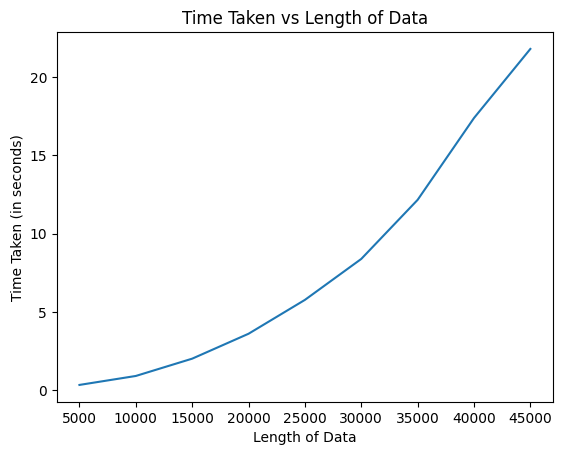

In [13]:
#Effect of size of the data train and data test on the computational time of the score
import time

time_taken = 0
times_taken = []
length_data = 5000
lengths_data = []

while time_taken < 20:

    representation_cur_test = representation_cur[:length_data]
    true_labels_num_test = true_labels_num[:length_data]

    #creating our model and train
    model_top = KNeighborsClassifier(n_neighbors=5)
    model_top.fit(X=representation_cur_test, y=true_labels_num_test)

    print(length_data)

    start_time = time.time()
    model_top.score(X=representation_cur_test, y=true_labels_num_test)
    end_time = time.time()
    time_taken = end_time - start_time

    print(time_taken)

    times_taken.append(time_taken)
    lengths_data.append(length_data)   

    length_data += 5000

plt.plot(lengths_data, times_taken)
plt.xlabel('Length of Data')
plt.ylabel('Time Taken (in seconds)')
plt.title('Time Taken vs Length of Data')
plt.show()


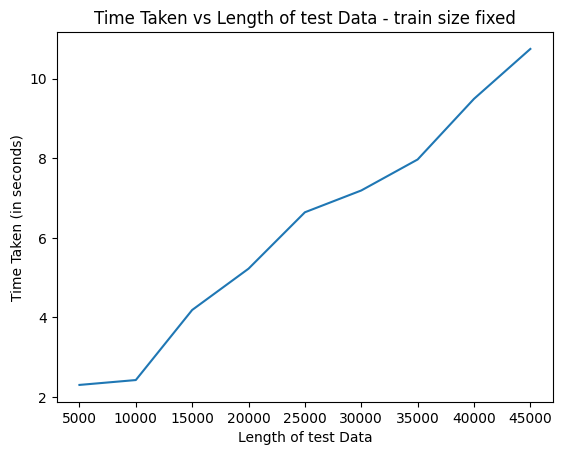

In [11]:
#Effect of size of the test data on the computational time of the score
import time

size_training = 10000 # we fix the size of the training data
time_taken = 0
times_taken = []
length_data = 5000
lengths_data = []

while time_taken < 10:

    representation_cur_train = representation_cur[:size_training]
    true_labels_num_train = true_labels_num[:size_training]

    representation_cur_test = representation_cur[:length_data]
    true_labels_num_test = true_labels_num[:length_data]

    #creating our model and train
    model_top = KNeighborsClassifier(n_neighbors=5)
    model_top.fit(X=representation_cur_train, y=true_labels_num_train)

    #print(length_data)

    start_time = time.time()
    model_top.score(X=representation_cur_test, y=true_labels_num_test)
    end_time = time.time()
    time_taken = end_time - start_time

    #print(time_taken)

    times_taken.append(time_taken)
    lengths_data.append(length_data)   

    length_data += 5000

plt.plot(lengths_data, times_taken)
plt.xlabel('Length of test Data')
plt.ylabel('Time Taken (in seconds)')
plt.title('Time Taken vs Length of test Data - train size fixed')
plt.show()

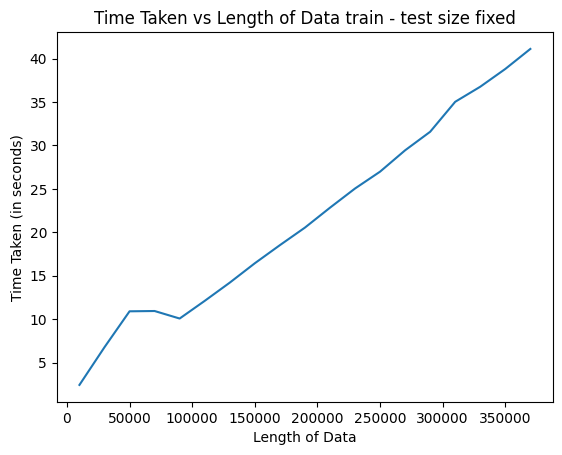

In [12]:
#Effect of size of the train data on the computational time of the score
import time

size_test = 10000 #we fix the size of the data test 
time_taken = 0
times_taken = []
length_data = 10000
lengths_data = []

while time_taken < 40:

    representation_cur_train = representation_cur[:length_data]
    true_labels_num_train = true_labels_num[:length_data]

    representation_cur_test = representation_cur[:size_test]
    true_labels_num_test = true_labels_num[:size_test]

    #creating our model and train
    model_top = KNeighborsClassifier(n_neighbors=5)
    model_top.fit(X=representation_cur_train, y=true_labels_num_train)

    #print(length_data)

    start_time = time.time()
    model_top.score(X=representation_cur_test, y=true_labels_num_test)
    end_time = time.time()
    time_taken = end_time - start_time

    #print(time_taken)

    times_taken.append(time_taken)
    lengths_data.append(length_data)   

    length_data += 20000

plt.plot(lengths_data, times_taken)
plt.xlabel('Length of Data')
plt.ylabel('Time Taken (in seconds)')
plt.title('Time Taken vs Length of Data train - test size fixed')
plt.show()


## Remark on plots 

- TO DO 

- The more data is used to fit our model, the more complex the computations for the prediction will be. 

100%|██████████| 5/5 [07:45<00:00, 93.04s/it]


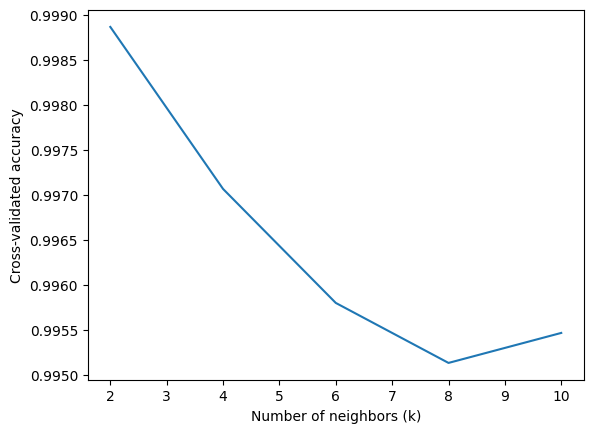

The optimal number of neighbors is 2


In [12]:

k_range = range(2, 11, 2)
k_scores = []
number_folds = 3

kf = KFold(n_splits=number_folds, shuffle=True)

for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = []

    for train_index, test_index in kf.split(representation_cur):
        X_train, X_test = representation_cur[train_index], representation_cur[test_index][:5000]
        y_train, y_test = true_labels_num[train_index], true_labels_num[test_index][:5000]
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        scores.append(score)
    k_scores.append(np.mean(scores))

plt.plot(k_range, k_scores)
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Cross-validated accuracy')
plt.show()

optimal_k = k_range[k_scores.index(max(k_scores))]
print("The optimal number of neighbors is", optimal_k)

## Choosing the right metrics

Let's the confusion matrix, which is a table that shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). In our case with the anonymisation, a true positive would be a text that contains personal data correctly identified as such, a true negative would be a text that does not contain personal data correctly identified as such, a false positive would be a text that does not contain personal data but is incorrectly identified as containing personal data, and a false negative would be a text that contains personal data but is not identified as such. So similarly to the case of spam emails, we are interested in the number of false negative. We want this value to be as low as possible, but at the same time we dont want our model to pin every non personal message as personal (we shouldnt have a number of false positives too high) as we would loose information. 

Once we get the confusion matrix, you can calculate several metrics such as precision, recall, and F1-score. Precision is the proportion of true positive predictions among all positive predictions, recall is the proportion of true positive predictions among all actual positive instances, and F1-score is the harmonic mean of precision and recall. These metrics will give you an idea of how well your model is performing in terms of detecting personal data.

In [14]:
from sklearn.model_selection import train_test_split

X_half1, X_half2, y_half1, y_half2 = train_test_split(representation_cur, true_labels_num, test_size=0.5, random_state=42)
X_quarter1, X_quarter2, y_quarter1, y_quarter2 = train_test_split(X_half1, y_half1, test_size=0.5, random_state=42)
X_quarter3, X_quarter4, y_quarter3, y_quarter4 = train_test_split(X_half2, y_half2, test_size=0.5, random_state=42)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_quarter1, y_quarter1, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_quarter2, y_quarter2, test_size=0.3, random_state=42)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_quarter3, y_quarter3, test_size=0.3, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_quarter4, y_quarter4, test_size=0.3, random_state=42)

In [19]:
#compute predictions
import time 

y_preds = []

for i in np.arange(1,5):

    start_time = time.time()
    
    knn = KNeighborsClassifier(n_neighbors=2)
    X_train_cur = globals()['X_train'+str(i)]
    y_train_cur = globals()['y_train'+str(i)]
    X_test_cur = globals()['X_test'+str(i)]
    y_test_cur = globals()['y_test'+str(i)]

    knn.fit(X_train_cur, y_train_cur)

    # make predictions on the test data
    y_pred = knn.predict(X_test_cur)
    y_preds.append(y_pred)
    
    end_time = time.time()
    time_taken = end_time - start_time
    print(time_taken)

86.6662950515747
91.79683804512024
90.85201382637024
96.53377103805542


In [23]:
#np.save(f"data/knn.preds.npy", y_preds)

In [28]:
y_preds = np.load("data/knn.preds.npy")

In [20]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

conf_matrices = []
precisions = []
recalls = []
f1s = []

for i in np.arange(4):
    y_pred_cur = y_preds[i]
    y_test_cur = globals()['y_test'+str(i+1)]

    # calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test_cur, y_pred_cur)
    conf_matrices.append(conf_matrix)

    # calculate performance metrics
    precision = precision_score(y_test_cur, y_pred_cur)
    precisions.append(precision)
    recall = recall_score(y_test_cur, y_pred_cur)
    recalls.append(recall)
    f1 = f1_score(y_test_cur, y_pred_cur)
    f1s.append(f1)

In [31]:
for i in np.arange(4):
    
    print("confusion ", i ," = ",conf_matrices[i])
    print("precision ", i ," = ",precisions[i])
    print("recall ", i ," = ",recalls[i])
    print("f1 score ", i ," = ",f1s[i])

print("")
print("The mean values for the metric are: ")

#mean_conf_matrix = np.mean(conf_matrices, axis=0)
#print(mean_conf_matrix)

# Calculate mean performance metrics
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1s)

print("mean precision", mean_precision)
print("mean recall", mean_recall)
print("mean f1", mean_f1)



confusion  0  =  [[57520    64]
 [  206  3288]]
precision  0  =  0.9809069212410502
recall  0  =  0.9410417859187178
f1 score  0  =  0.9605609114811569
confusion  1  =  [[57606    69]
 [  222  3181]]
precision  1  =  0.9787692307692307
recall  1  =  0.9347634440199823
f1 score  1  =  0.9562603336840524
confusion  2  =  [[57676    71]
 [  205  3126]]
precision  2  =  0.9777916796997185
recall  2  =  0.9384569198438907
f1 score  2  =  0.957720588235294
confusion  3  =  [[57656    67]
 [  212  3143]]
precision  3  =  0.9791277258566978
recall  3  =  0.9368107302533532
f1 score  3  =  0.9575019040365575

The mean values for the metric are: 
mean precision 0.9791488893916743
mean recall 0.9377682200089861
mean f1 0.9580109343592651


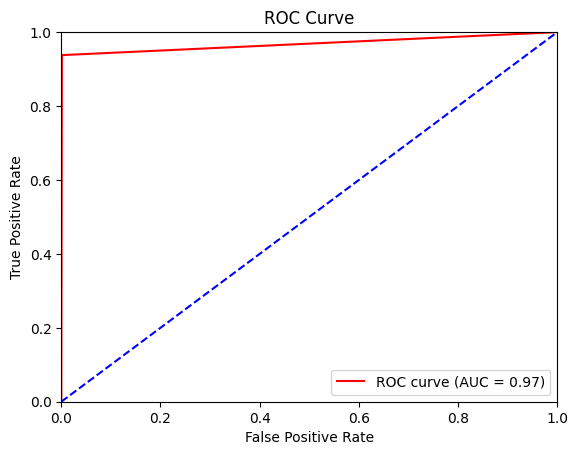

In [40]:

y_preds_all = np.concatenate(y_preds)
y_test_all = np.concatenate([globals()['y_test'+str(i+1)] for i in np.arange(4)])


false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test_all, y_preds_all)
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, color='red', label='ROC curve (AUC = {})'.format(np.round(roc_auc, 2)))
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve') #meaning Receiver Operating Characteristic
plt.show()

## Remark

The ROC curve that we obtained is very close to the top-left corner of the plot, it indicates that the model has higher true positive rate and lower false positive rate, which is desirable. If the curve was closer to the diagonal line , it would mean the model performance would be poor (as the diagonal indicates random guessing).

Therefore, we get a high area under the curve (AUC score) of 0.97, it suggests that our model is capable of correctly identifying the vast majority of our positive samples while keeping at the same time false positives to a minimum, indicating good performance in classifying personal and non personal text.